### Task

1. Download the data set of marketing campaigns from here https://www.kaggle.com/davinwijaya/customer-retention
2. The conversion field is the target variable, and the offer is the communication. Rename the fields (conversion -> target, offer -> treatment) and bring the treatment field to a binary form (1 or 0, i.e. there was some kind of offer or not) - the value No Offer means no communication, and all the others - availability.
3. Split the dataset into non-training and test samples
4. Make feature engineering at your discretion (freedom of choice of methods is allowed)
5. Perform uplift modeling in 3 ways: one model with a communication feature (S learner), a model with a target transformation (transformation of classes of clause 2.1) and a variant with two independent models
6. At the end, output a single table comparing the metrics uplift@10%, uplift@20% of these 3 models
7. Build an UpliftTreeClassifier model and try to describe the resulting tree in words
8. *For the S learner model (a model with an additional sign of communication), build a dependence of the target (conversion - conversion field) on the uplift value: 1) make a forecast and get an uplift for the test sample 2) sort the test sample by uplift in descending order 3) split into deciles (pandas qcut to help you) 4) calculate the average conversion for each decile
9. *Build an UpliftRandomForestClassifier model and try to describe the resulting tree in words

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

# Additional links
1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html
9. https://habr.com/ru/company/ru_mts/blog/538934/

# I Libraries and Functions

## 1 Importing libraries

In [1]:
!pip install scikit-uplift catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 549.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.9 MB/s eta 0:00:00


In [69]:
import os
import shutil
import time
from google.colab import drive, files
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd; pd.set_option('display.max_columns', None)
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_by_percentile, weighted_average_uplift
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier
from sklift.viz import plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile, plot_uplift_preds
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle

## 2 Definition of functions

In [84]:
star = lambda x:"\n" + x*50 + "\n"

def Mkdir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)


def build_model(model, X_train, X_val, y_train, y_val, treat_train, treat_val, k_value):
    M = model
    M_fit = M.fit(X_train, y_train, treat_train)
    M_uplift = M_fit.predict(X_val)
    M_score = uplift_at_k(y_true=y_val, uplift=M_uplift, treatment=treat_val, strategy="by_group", k=k_value)
    return M_fit, M_score, M_uplift


def save_model(path, model_name):
    with open(path, "wb") as mod:
        pickle.dump(model_name, mod)


def load_model(path, model_name):
    with open(path, "rb") as mod1:
        model_name = pickle.load(mod1)
    return model_name

# II Preporation Data

## 3 Load datasets

In [4]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
path_to_work_dir = "/content/drive/MyDrive/HW4_MOB/"

In [ ]:
# Mkdir(path_to_work_dir)

In [ ]:
df = pd.read_csv(path_to_work_dir + "HW_data.csv")
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


## 4 Transformation of features

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df.replace({"channel": {"Web": 0, "Phone": 1, "Multichannel": 1},
                  "zip_code": {"Surburban": 0, "Rural": 0, "Urban": 1}}, inplace=True)
df["treatment"].where(df["treatment"].values == "No Offer", 1, inplace=True)
df["treatment"].mask(df["treatment"].values == "No Offer", 0, inplace=True)
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,0,0,1,1,0
1,6,329.08,1,1,0,1,0,0,0
2,7,180.65,0,1,0,1,0,1,0
3,9,675.83,1,0,0,1,0,1,0
4,2,45.34,1,0,1,0,0,1,0


In [ ]:
df["treatment"] = df["treatment"].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  int64  
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  int64  
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.4 MB


In [ ]:
S = StandardScaler()
S.fit(df["history"].values.reshape(-1, 1))
df["history"] = S.transform(df["history"].values.reshape(-1, 1))
S.fit(df["recency"].values.reshape(-1, 1))
df["recency"] = S.transform(df["recency"].values.reshape(-1, 1))
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,1.207751,-0.389003,1,0,0,0,1,1,0
1,0.067359,0.339614,1,1,0,1,0,0,0
2,0.352457,-0.239836,0,1,0,1,0,1,0
3,0.922653,1.693278,1,0,0,1,0,1,0
4,-1.073034,-0.768068,1,0,1,0,0,1,0
5,0.067359,-0.418711,0,1,0,0,1,1,1
6,0.922653,0.148793,1,0,0,1,1,1,0
7,0.922653,-0.763852,0,1,1,0,1,1,0
8,0.922653,1.690311,1,1,0,1,1,1,0
9,1.207751,-0.816866,0,1,1,1,0,1,0


In [ ]:
# df.to_csv(path_to_work_dir + "df_scal.csv", sep=",", index=None)

In [54]:
df = pd.read_csv(path_to_work_dir + "df_scal.csv")
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,1.207751,-0.389003,1,0,0,0,1,1,0
1,0.067359,0.339614,1,1,0,1,0,0,0
2,0.352457,-0.239836,0,1,0,1,0,1,0
3,0.922653,1.693278,1,0,0,1,0,1,0
4,-1.073034,-0.768068,1,0,1,0,0,1,0
5,0.067359,-0.418711,0,1,0,0,1,1,1
6,0.922653,0.148793,1,0,0,1,1,1,0
7,0.922653,-0.763852,0,1,1,0,1,1,0
8,0.922653,1.690311,1,1,0,1,1,1,0
9,1.207751,-0.816866,0,1,1,1,0,1,0


## 5 Split dataset on train and test data

### 5.1 Review target value

In [55]:
df['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [56]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [57]:
df_train.shape, df_test.shape

((44800, 9), (19200, 9))

In [58]:
df_train["target"].value_counts()

0    38217
1     6583
Name: target, dtype: int64

In [59]:
df_test["target"].value_counts()

0    16389
1     2811
Name: target, dtype: int64

In [60]:
X_train = df_train.drop(["treatment", "target"], axis=1)
y_train = df_train["target"]
treat_train = df_train["treatment"]

X_val = df_test.drop(["treatment", "target"], axis=1)
y_val = df_test["target"]
treat_val = df_test["treatment"]

## 6 Build models

In [36]:
models_results = {
    "approach": [],
    "uplift10%": [],
    "uplift20%": []
}

In [37]:
model_sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))

model_cat = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))

model_two_models = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='vanilla'
)

## 7 Train models

In [38]:
SM_10, sm_score_10, sm_uplift_10 = build_model(model_sm, X_train, X_val, y_train, y_val, treat_train, treat_val, 0.1)

models_results["approach"].append("SoloModel")
models_results["uplift10%"].append(sm_score_10)

In [39]:
SM_20, sm_score_20, sm_uplift_20 = build_model(model_sm, X_train, X_val, y_train, y_val, treat_train, treat_val, 0.2)

models_results["uplift20%"].append(sm_score_20)

In [40]:
CTF_10, ctf_score_10, ctf_uplift_10 = build_model(model_cat, X_train, X_val, y_train, y_val, treat_train, treat_val, 0.1)

models_results["approach"].append("ClassTransformation")
models_results["uplift10%"].append(ctf_score_10)

In [41]:
CTF_20, ctf_score_20, ctf_uplift_20 = build_model(model_cat, X_train, X_val, y_train, y_val, treat_train, treat_val, 0.2)

models_results["uplift20%"].append(ctf_score_20)

In [42]:
TW_10, tw_score_10, tw_uplift_10 = build_model(model_two_models, X_train, X_val, y_train, y_val, treat_train, treat_val, 0.1)

models_results["approach"].append("TwoModels")
models_results["uplift10%"].append(tw_score_10)

In [43]:
TW_20, tw_score_20, tw_uplift_20 = build_model(model_two_models, X_train, X_val, y_train, y_val, treat_train, treat_val, 0.2)

models_results["uplift20%"].append(tw_score_10)

## 8 Save and Load models

In [75]:
# Mkdir(path_to_work_dir + "SM_10/")
# Mkdir(path_to_work_dir + "SM_20/")
# Mkdir(path_to_work_dir + "CTF_10/")
# Mkdir(path_to_work_dir + "CTF_20/")
# Mkdir(path_to_work_dir + "TW_10/")
# Mkdir(path_to_work_dir + "TW_20/")

In [76]:
path_to_sm10_model = path_to_work_dir + "SM_10/model_sm10.pkl"
path_to_sm20_model = path_to_work_dir + "SM_20/model_sm20.pkl"
path_to_ctf10_model = path_to_work_dir + "CTF_10/model_ctf10.pkl"
path_to_ctf20_model = path_to_work_dir + "CTF_20/model_ctf20.pkl"
path_to_tw10_model = path_to_work_dir + "TW_10/model_tw10.pkl"
path_to_tw20_model = path_to_work_dir + "TW_20/model_tw20.pkl"

In [82]:
# save_model(path_to_sm10_model, SM_10)
# save_model(path_to_sm20_model, SM_20)
# save_model(path_to_ctf10_model, CTF_10)
# save_model(path_to_ctf20_model, CTF_20)
# save_model(path_to_tw10_model, TW_10)
# save_model(path_to_tw20_model, TW_20)

In [83]:
SM_10 = load_model(path_to_sm10_model, SM_10)
SM_20 = load_model(path_to_sm20_model, SM_20)
CTF_10 = load_model(path_to_ctf10_model, CTF_10)
CTF_20 = load_model(path_to_ctf20_model, CTF_20)
TW_10 = load_model(path_to_tw10_model, TW_10)
TW_20 = load_model(path_to_tw20_model, TW_20)

In [44]:
df_model = pd.DataFrame(models_results)

In [86]:
# df_model.to_csv(path_to_work_dir + "df_model.csv", sep=",", index=None)

In [87]:
df_model = pd.read_csv(path_to_work_dir + "df_model.csv")
df_model

,approach,uplift10%,uplift20%
0,SoloModel,0.120512,0.091226
1,ClassTransformation,0.115176,0.105376
2,TwoModels,0.074378,0.074378


In [46]:
uplift_dict = {"sm_10": sm_uplift_10,
               "sm_20": sm_uplift_20,
               "ctf_10": ctf_uplift_10,
               "cft_20": ctf_uplift_20,
               "tw_10": tw_uplift_10,
               "tw_20": tw_uplift_20}

## 9 Vizualization uplift_curve

In [47]:
uplift_dict_key = iter(uplift_dict.keys())
uplift_dict_val = iter(uplift_dict.values())

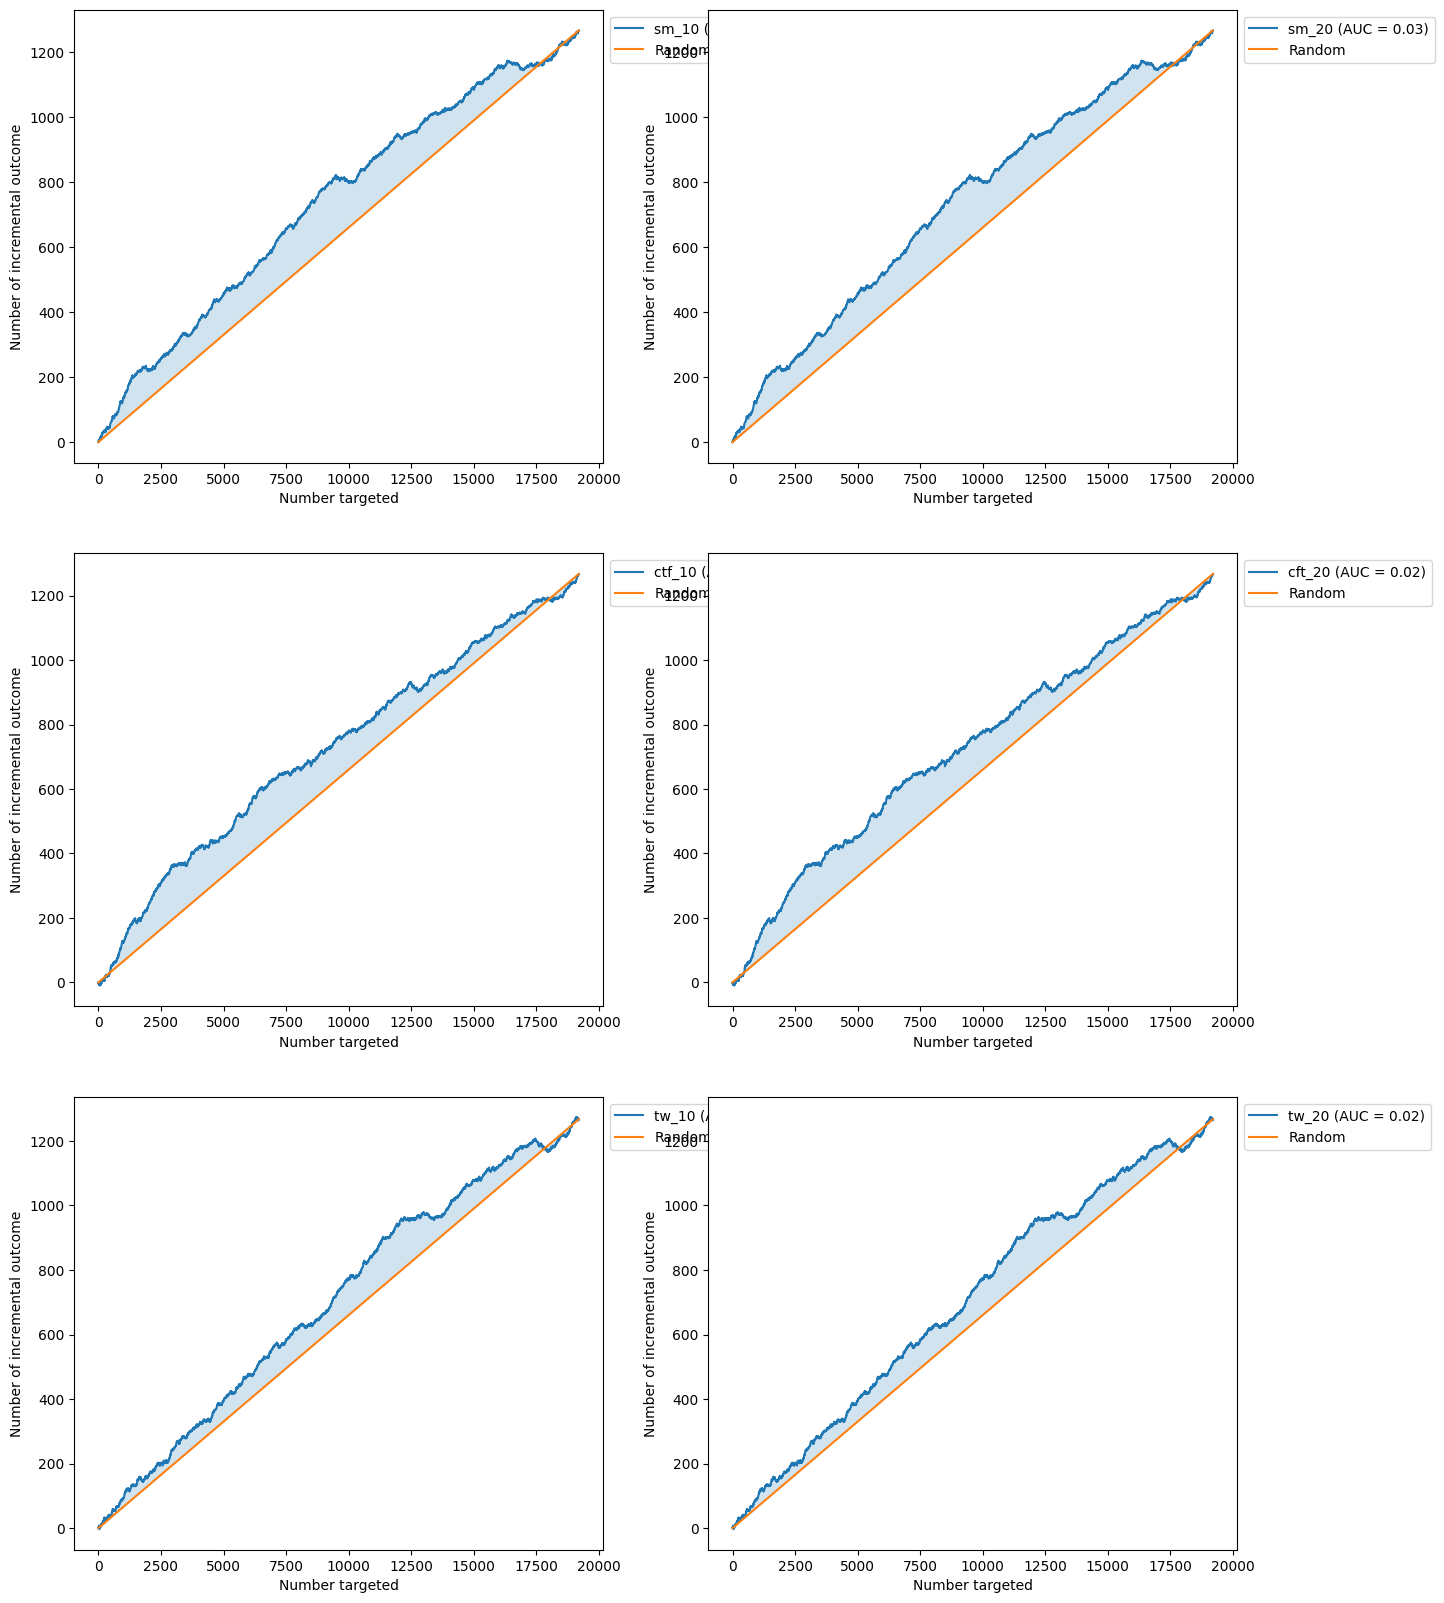

In [48]:
fig, axes = plt.subplots(3,2, figsize=(15,20))
for i in range(3):
    for j in range(2):
        plot_uplift_curve(y_val, next(uplift_dict_val), treat_val, perfect=False, name=next(uplift_dict_key), ax=axes[i,j])

## 10 Review uplift's models

In [49]:
df_uplift = pd.DataFrame(uplift_dict)

In [88]:
# df_uplift.to_csv(path_to_work_dir + "df_uplift.csv", sep=",", index=None)

In [89]:
df_uplift = pd.read_csv(path_to_work_dir + "df_uplift.csv")
df_uplift

,sm_10,sm_20,ctf_10,cft_20,tw_10,tw_20
0,0.047052,0.047052,-0.271742,-0.271742,0.001152,0.001152
1,0.076653,0.076653,-0.136835,-0.136835,0.084470,0.084470
2,0.080424,0.080424,-0.164094,-0.164094,0.088942,0.088942
3,0.059402,0.059402,-0.217658,-0.217658,0.074771,0.074771
4,0.154054,0.154054,-0.020567,-0.020567,0.187552,0.187552
...,...,...,...,...,...,...
19195,0.030205,0.030205,-0.213184,-0.213184,0.046791,0.046791
19196,0.042492,0.042492,-0.179179,-0.179179,-0.025347,-0.025347
19197,0.060713,0.060713,-0.151310,-0.151310,0.080388,0.080388
19198,0.032996,0.032996,-0.195338,-0.195338,0.053218,0.053218


In [90]:
n = 15
dff = pd.DataFrame({
    'true': y_val[:n],
    'uplift': uplift_dict["sm_20"][:n],
    'treat': treat_val[:n]
})
dff

,true,uplift,treat
33042,0,0.047052,1
7209,0,0.076653,1
24367,0,0.080424,1
19599,1,0.059402,1
31465,1,0.154054,1
32504,0,0.068754,0
23080,1,0.075882,1
7168,0,0.026407,0
26195,0,0.032147,0
36096,0,0.040444,0
